In [29]:
# we import the necessary libraries and establish a connection
import sim
import math  
from math import cos, sin, pi
import time
import random
      
def connect(port):

    sim.simxFinish(-1) # just in case, close all opened connections
    clientID=sim.simxStart('127.0.0.1',port,True,True,2000,5) # Connect
    if clientID == 0: print("connected to", port)
    else: print("could not connect")
    return clientID


In [30]:
# UTILS

def calculate_wheel_velocities(speed, rotation, orientation):
    alpha = [0, 2 * math.pi / 3, -2 * math.pi / 3]  
    Vx = speed * cos(orientation)
    Vy = speed * sin(orientation)
    WheelRadius = 0.053
    omega = rotation / WheelRadius
    
    V_wheels = []
    for a in alpha:
        V_wheel = -Vx * cos(a) + Vy * sin(a) + omega * WheelRadius
        V_wheels.append(V_wheel)
    
    return V_wheels

def calc_h(distance_front, distance_back):
    c = math.sqrt(distance_front**2 + distance_back**2)
    h = distance_front * distance_back / c
    return h


In [31]:
WheelRadius = 0.053
robot_radius = 0.12
dt = 0.1
odometry = []
corners = []

In [32]:
class OmniBot:
    
    def __init__(self):
        # Flags activated if distance is less than 20 cm
        self.followingWall = False
        self.flagSideBack = False
        self.flagSideLeft = False
        self.flagSideRight = False
        self.movement = 0  # 1:right, -1:left, 2:forward
        self.distance = float('inf')
        self.dist_diff = -1
        self.generated_movement = False
        self.vel1 = 0
        self.vel2 = 0
        self.vel3 = 0
        self.Ypos = 2.875
        self.Xpos = -2.575
        self.theta = math.pi / 2
        
        self.clientID = clientID

        # Motors
        self.wheelFront = self.get_handle('omniFront')
        self.wheelLeft = self.get_handle('omniLeft')
        self.wheelRight = self.get_handle('omniRight')
        
        # Sensors
        self.sensorBack = self.get_handle('sensorBack')
        self.sensorLeft = self.get_handle('sensorLeft')
        self.sensorRight = self.get_handle('sensorRight')

        # Start sensors
        self.start_sensor(self.sensorBack)
        self.start_sensor(self.sensorLeft)
        self.start_sensor(self.sensorRight)
        
        # Odometry
        self.odometry = self.get_handle('odometry')
        self.robot = self.get_handle('Base_robot')
        
    def get_handle(self, name):
        res, handle = sim.simxGetObjectHandle(self.clientID, name, sim.simx_opmode_blocking)
        return handle

    def start_sensor(self, sensor):
        sim.simxReadProximitySensor(self.clientID, sensor, sim.simx_opmode_streaming)
    
    def move_robot(self, speed, rotation, orientation):
        wheel_velocities = calculate_wheel_velocities(speed, rotation, orientation)
        
        self.vel1 = wheel_velocities[1]
        self.vel2 = wheel_velocities[2]
        self.vel3 = wheel_velocities[0]
    
        sim.simxSetJointTargetVelocity(self.clientID, self.wheelFront, wheel_velocities[0], sim.simx_opmode_oneshot)
        sim.simxSetJointTargetVelocity(self.clientID, self.wheelLeft, wheel_velocities[1], sim.simx_opmode_oneshot)
        sim.simxSetJointTargetVelocity(self.clientID, self.wheelRight, wheel_velocities[2], sim.simx_opmode_oneshot)
    
    def correct_theta(self):
        if 3 * math.pi / 4 > self.theta > math.pi / 4:
            self.theta = math.pi / 2
        elif 5 * math.pi / 4 > self.theta > 3 * math.pi / 4:
            self.theta = math.pi
        elif 7 * math.pi / 4 > self.theta > 5 * math.pi / 4:
            self.theta = 3 * math.pi / 2
        else:
            self.theta = 0
    
    def stop(self):
        self.move_robot(0, 0, 0)

    def get_distance(self, sensor):
        _, detectionState, detectedPoint, _, _ = sim.simxReadProximitySensor(self.clientID, sensor, sim.simx_opmode_buffer)
        if detectionState == 1:
            distance_cm = math.sqrt(sum(i**2 for i in detectedPoint)) * 100  # cm
            return round(distance_cm, 1)
        return 9999

    def sweeping(self):
        print('Sweeping')
        min_distance = float('inf')
        start_time = time.time()
        
        while time.time() - start_time < 1:
            distance = self.get_distance(self.sensorBack)
            if distance < 50:
                min_distance = min(min_distance, distance)
            self.move_robot(0, -(12.5/distance) * self.movement, 0)
            
        start_time = time.time()
        while time.time() - start_time < 2:
            distance = self.get_distance(self.sensorBack)
            if distance < 50:
                min_distance = min(min_distance, distance)
            self.move_robot(0, (12.5/distance) * self.movement, 0)
        
        if min_distance < 50:
            distance = self.get_distance(self.sensorBack)
            while abs(distance - min_distance) > 0.5:
                distance = self.get_distance(self.sensorBack)
                self.move_robot(0, -(12.5/distance) * self.movement, 0)
            
            while int(distance) > 20:
                self.update_odometry(dt)
                self.move_robot(1, 0, math.pi / 2)
                distance = self.get_distance(self.sensorBack)
            self.followingWall = True
            corners.append((self.Xpos, self.Ypos))
            print('FollowingWalls')
        else:
            self.move_robot(0, -(12.5/distance) * self.movement, 0)
            time.sleep(1)
        self.stop()
    
    def get_dist_diff(self):
        distance = self.get_distance(self.sensorBack)
        diff_dist = self.distance - distance
        return distance, diff_dist

    def correct_position(self):
        distance = self.get_distance(self.sensorBack)
        diff_dist = self.distance - distance
        self.distance = distance
        dist_diff_th = self.dist_diff - 3 < diff_dist < self.dist_diff + 3

        if distance < 15 and dist_diff_th:
            print('Correcting position')
            while distance < 20:
                distance = self.get_distance(self.sensorBack)
                self.move_robot(1, 0, 3 * math.pi / 2)
            self.stop()
            time.sleep(0.1)
            self.move_robot(0, -0.1 * self.movement, 0)
            time.sleep(0.5)
        elif distance > 30 and dist_diff_th:
            self.update_odometry(1)
            time.sleep(1)
            print('Correcting position')
            distance = self.get_distance(self.sensorBack)
            if distance > 50:
                print('Not following wall')
                self.followingWall = False
                corners.append((self.Xpos, self.Ypos))
                return
            while distance > 20:
                distance = self.get_distance(self.sensorBack)
                self.move_robot(1, 0, math.pi / 2)
            self.stop()
            time.sleep(0.1)
            self.move_robot(0, 0.1 * self.movement, 0)
            time.sleep(0.5)
        self.distance = distance
        self.dist_diff = diff_dist

    def set_flags(self):
        self.flagSideRight = self.get_distance(self.sensorRight) < 20
        self.flagSideLeft = self.get_distance(self.sensorLeft) < 20
        if self.movement != 2:
            self.flagSideBack = self.get_distance(self.sensorBack) < 50

    def move_to_turn(self):
        while self.get_distance(self.sensorBack) < 20:
            self.move_robot(1, 0, 3 * math.pi / 2)
        self.stop()
        while self.get_distance(self.sensorRight) < 20 or self.get_distance(self.sensorLeft) < 20:
            self.move_robot(1, 0, math.pi / 2 - self.movement * math.pi / 2)
        self.stop()
    
    def update_odometry(self, t):
        result = self.calculate_odometry(self.vel1, self.vel2, self.vel3)
        
        self.theta += result[2] * t / dt
        
        if self.theta >= 2 * math.pi:
            self.theta -= 2 * math.pi
        elif self.theta <= 0:
            self.theta += 2 * math.pi
            
        if 3 * math.pi / 4 > self.theta > math.pi / 4:
            self.Xpos -= result[1] * t * 2.25
            self.Ypos += result[0] * t * 2.25
        elif 5 * math.pi / 4 > self.theta > 3 * math.pi / 4:
            self.Xpos -= result[0] * t * 2.25
            self.Ypos -= result[1] * t * 2.25
        elif self.theta < math.pi / 4 or self.theta > 7 * math.pi / 4:
            self.Xpos += result[0] * t * 2.25
            self.Ypos += result[1] * t * 2.25
        elif 7 * math.pi / 4 > self.theta > 5 * math.pi / 4:
            self.Xpos += result[1] * t * 2.25
            self.Ypos -= result[0] * t * 2.25
        
        sim.simxSetObjectPosition(self.clientID, self.odometry, -1, [self.Xpos, self.Ypos, 0], sim.simx_opmode_oneshot)
        sim.simxSetObjectOrientation(self.clientID, self.odometry, -1, [0, 0, self.theta], sim.simx_opmode_oneshot)
        
        odometry.append((self.Xpos, self.Ypos, self.theta))
        
        time.sleep(dt)
    
    def calculate_odometry(self, w1, w2, w3):
        V1 = w1 * WheelRadius
        V2 = w2 * WheelRadius
        V3 = w3 * WheelRadius
        
        Vx = V3 - V2 * math.sin(math.radians(30)) - V1 * math.sin(math.radians(30))
        Vy = V1 * math.cos(math.radians(30)) - V2 * math.cos(math.radians(30))
        w = (WheelRadius / (3 * robot_radius)) * (w1 + w2 + w3)
        
        return [Vx, Vy, w]
        
    def wall_following(self):
        while True:
            self.update_odometry(dt)
            if not self.followingWall:
                self.generated_movement = False
                self.movement = 2
                self.move_robot(1, 0, math.pi / 2)  # Move forward
                distance = self.get_distance(self.sensorBack)
                if distance < 50:
                    self.stop()
                    self.sweeping()
                    self.correct_theta()
            else:
                if not self.generated_movement:
                    if self.get_distance(self.sensorLeft) < 75:
                        self.movement = -1
                    elif self.get_distance(self.sensorRight) < 75:
                        self.movement = 1
                    else:
                        self.movement = random.choice([1, -1])
                    self.generated_movement = True
                    corners.append((self.Xpos, self.Ypos))
                
                self.set_flags()
                if not self.flagSideRight and not self.flagSideLeft:                   
                    self.move_robot(1, 0, math.pi / 2 + self.movement * math.pi / 2)  # Move sideways
                    if not self.flagSideBack:
                        time.sleep(1)
                        self.followingWall = False
                        corners.append((self.Xpos, self.Ypos))
                    else:
                        self.correct_position()
                        self.set_flags()
                else:
                    self.stop()
                    self.move_to_turn()
                    self.move_robot(0, -1 * self.movement, 0)
                    self.theta -= self.movement * pi/2
                    corners.append((self.Xpos, self.Ypos))
                    time.sleep(1)
                    self.sweeping()
                    self.correct_theta()
                    self.update_odometry(dt)
                    self.set_flags()

In [34]:
clientID = connect(19999)
robot = OmniBot()

robot.wall_following()

connected to 19999
Sweeping
FollowingWalls
Correcting position
Sweeping
FollowingWalls
Correcting position
Correcting position
Correcting position
Sweeping
FollowingWalls
Correcting position
Correcting position
Sweeping
FollowingWalls
Correcting position
Correcting position
Sweeping
FollowingWalls
Correcting position
Sweeping
FollowingWalls
Correcting position
Sweeping
FollowingWalls
Correcting position
Correcting position
Correcting position
Sweeping
FollowingWalls
Correcting position
Sweeping
FollowingWalls
Correcting position
Sweeping
FollowingWalls
Correcting position
Sweeping
FollowingWalls
Correcting position
Correcting position
Correcting position
Sweeping
FollowingWalls
Correcting position
Correcting position
Sweeping
FollowingWalls
Correcting position


KeyboardInterrupt: 

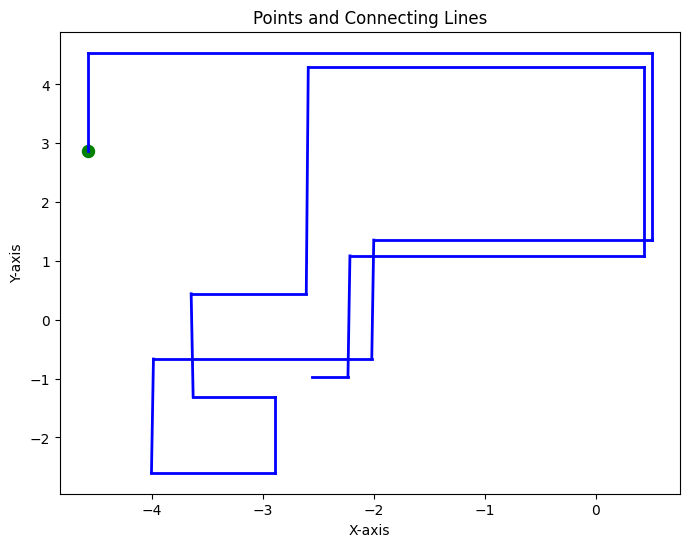

In [42]:
import matplotlib.pyplot as plt

points = corners#[(x, y) for x, y, z in odometry]

# Create a new figure and plot
plt.figure(figsize=(8, 6))  # Adjust figure size as needed

# Extract x and y coordinates from the list
x_points = [point[0] for point in points[1:]]
y_points = [point[1] for point in points[1:]]

# Plot lines between consecutive points
for i in range(len(x_points) - 1):
  plt.plot([x_points[i], x_points[i + 1]], [y_points[i], y_points[i + 1]], color='blue', linewidth=2)

# Plot points with markers
#plt.scatter(x_points, y_points, marker='o', c='red', s=50)  # Adjust marker style, color, and size
plt.scatter(points[0][0], points[0][1], marker='o', c='green', s=75)

# Set labels and title for the axes
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Points and Connecting Lines')

# Set axis limits (optional)
# plt.xlim([0, 10])  # Set X-axis limits
# plt.ylim([0, 10])  # Set Y-axis limits

# Display the plot
plt.show()


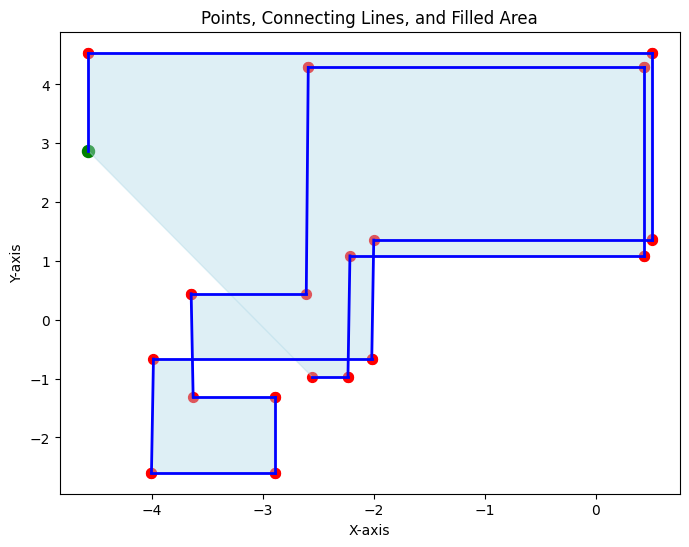

In [43]:
import matplotlib.patches as patches

# Create a new figure and plot
plt.figure(figsize=(8, 6))  # Adjust figure size as needed

# Extract x and y coordinates from the list
x_points = [point[0] for point in points[1:]]
y_points = [point[1] for point in points[1:]]

# Plot lines between consecutive points
for i in range(len(x_points) - 1):
    plt.plot([x_points[i], x_points[i + 1]], [y_points[i], y_points[i + 1]], color='blue', linewidth=2)

# Plot points with markers
plt.scatter(x_points, y_points, marker='o', c='red', s=50)  # Adjust marker style, color, and size
plt.scatter(points[0][0], points[0][1], marker='o', c='green', s=75)

# Set labels and title for the axes
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Points, Connecting Lines, and Filled Area')

# Create a list of vertices for the polygon
vertices = []
for i in range(len(x_points)):
    vertices.append((x_points[i], y_points[i]))
vertices.append((x_points[-1], y_points[-1]))  # Close the polygon at the last point
vertices.append(points[0])  # Add starting point to close the figure

# Create a polygon patch with desired color and alpha (transparency)
polygon = patches.Polygon(xy=vertices, color='lightblue', alpha=0.4)

# Add the polygon to the plot
plt.gca().add_patch(polygon)

# Display the plot
plt.show()


In [49]:
non_duplicated_corners = []
for i in range(len(corners) - 1):
    if corners[i] != corners[i+1]:
        non_duplicated_corners.append(corners[i])
        
if corners[-1] != corners[-2]:
    non_duplicated_corners.append(corners[-1])